In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from llama import Workflow, Llama

os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29502"

workflow = Workflow.build(
    ckpt_dir='/scratch4/jeisner1/tjbai/llama_8b',
    tokenizer_path='/scratch4/jeisner1/tjbai/llama_8b/tokenizer.model',
    max_seq_len=8192,
    max_batch_size=8,
    model_parallel_size=1,
    max_nodes=100,
)

llama = Llama(workflow.model, workflow.tokenizer)

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loaded in 26.58 seconds


In [19]:
import numpy as np
from llama.workflows.prisoners import prisoners_baseline, baseline_nll

baseline_outputs = prisoners_baseline(
    llama=llama,
    payoff=(5, 3, 1, 0),
    alice_first=True,
    alice_strategy=None,
    temperature=1.0,
    top_p=1.0,
)

print(-np.mean(baseline_outputs['bob_log_probs'][0]))

nll = baseline_nll(
    llama, baseline_outputs,
    payoff=(5, 3, 1, 0),
    alice_first=True,
    alice_strategy=None,
)

print(np.mean(nll['bob_nll'][0]))

1.0237316084772932
1.0225695927887126


In [7]:
import numpy as np
from llama.workflows.prisoners import prisoners_cached, cached_nll

workflow.reset()
cached_outputs = prisoners_cached(
    workflow=workflow,
    payoff=(5, 3, 1, 0),
    alice_first=False,
    alice_strategy=None,
)

print(-(sum(cached_outputs['bob_log_probs'][0]) / len(cached_outputs['bob_log_probs'][0])).cpu().item())

0.8704151511192322


In [9]:
from llama.workflows.prisoners import cached_nll

nll = cached_nll(
    workflow, cached_outputs,
    payoff=(5, 3, 1, 0),
    alice_first=False,
    alice_strategy=None,
)

np.mean(nll['bob_nll'][0])

0.8746917659729169

In [10]:
import json

with open('/home/tbai4/llama3/dumps/prisoners/prisoners_baseline.jsonl') as f:
    data = [json.loads(line) for line in f]
    
baseline_no_strategy = [d['outputs'] for d in data[:100]]
baseline_always_cooperate = [d['outputs'] for d in data[101:200]]
baseline_always_defect = [d['outputs'] for d in data[200:]]

with open('/home/tbai4/llama3/dumps/prisoners/prisoners_cached_paired.jsonl') as f:
    data = [json.loads(line) for line in f]
    
cached_no_strategy = [d['outputs'] for d in data[:100]]
cached_always_cooperate = [d['outputs'] for d in data[101:200] if d['strategy'] == 'always_cooperate']
cached_always_defect = [d['outputs'] for d in data[200:300] if d['strategy'] == 'always_defect']

## no strategy

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from llama.workflows.prisoners import baseline_nll, cached_nll

def plot(outputs, differences):
    baseline_res = []    
    for i, b in tqdm(enumerate(outputs)):
        try:
            baseline_res.append(baseline_nll(
                llama, b,
                payoff=(5,3,1,0),
                alice_first=(i < 50),
                alice_strategy=None
            ))
        except:
            baseline_res.append({'bob_nll': [[1e9], [1e9]], 'alice_nll': [[1e9], [1e9]]})

    cached_res = []
    for i, b in tqdm(enumerate(outputs)):
        try:
            cached_res.append(cached_nll(
                workflow, b,
                payoff=(5,3,1,0),
                alice_first=(i < 50),
                alice_strategy=None,
            ))
        except:
            cached_res.append({'bob_nll': [[1e9], [1e9]], 'alice_nll': [[1e9], [1e9]]})

    sns.set_theme()

    baseline_first_means = [np.mean(b['bob_nll'][0]) for b in baseline_res]
    cached_first_means = [np.mean(b['bob_nll'][0]) for b in cached_res]

    baseline_second_means = [np.mean(b['bob_nll'][1]) for b in baseline_res]
    cached_second_means = [np.mean(b['bob_nll'][1]) for b in cached_res]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.scatter(
        [baseline_first_means[i] for i in range(len(baseline_first_means)) if not differences[i]],
        [cached_first_means[i] for i in range(len(cached_first_means)) if not differences[i]],
        s=100, alpha=0.7, color='blue', label='Same decision'
    )
    ax1.scatter(
        [baseline_first_means[i] for i in range(len(baseline_first_means)) if differences[i]],
        [cached_first_means[i] for i in range(len(cached_first_means)) if differences[i]],
        s=100, alpha=0.7, color='red', label='Different decision'
    )
    ax1.set_xlim(0, 1.5)
    ax1.set_ylim(0, 1.5)
    ax1.plot([0, 1.5], [0, 1.5], 'k--', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('First Message')
    ax1.set_xlabel('Baseline NLL')
    ax1.set_ylabel('Choreographed NLL')
    ax1.legend()

    ax2.scatter(
        [baseline_second_means[i] for i in range(len(baseline_second_means)) if not differences[i]],
        [cached_second_means[i] for i in range(len(cached_second_means)) if not differences[i]],
        s=100, alpha=0.7, color='blue', label='Same decision'
    )
    ax2.scatter(
        [baseline_second_means[i] for i in range(len(baseline_second_means)) if differences[i]],
        [cached_second_means[i] for i in range(len(cached_second_means)) if differences[i]],
        s=100, alpha=0.7, color='red', label='Different decision'
    )
    ax2.set_xlim(0, 1.5)
    ax2.set_ylim(0, 1.5)
    ax2.plot([0, 1.5], [0, 1.5], 'k--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Second Message')
    ax2.set_xlabel('Baseline NLL')
    ax2.set_ylabel('Choreographed NLL')
    ax2.legend()

    for ax in [ax1, ax2]:
        sns.despine(ax=ax)

    plt.tight_layout()
    return fig

100it [02:19,  1.39s/it]
100it [00:59,  1.69it/s]
100it [02:14,  1.35s/it]
100it [00:57,  1.73it/s]


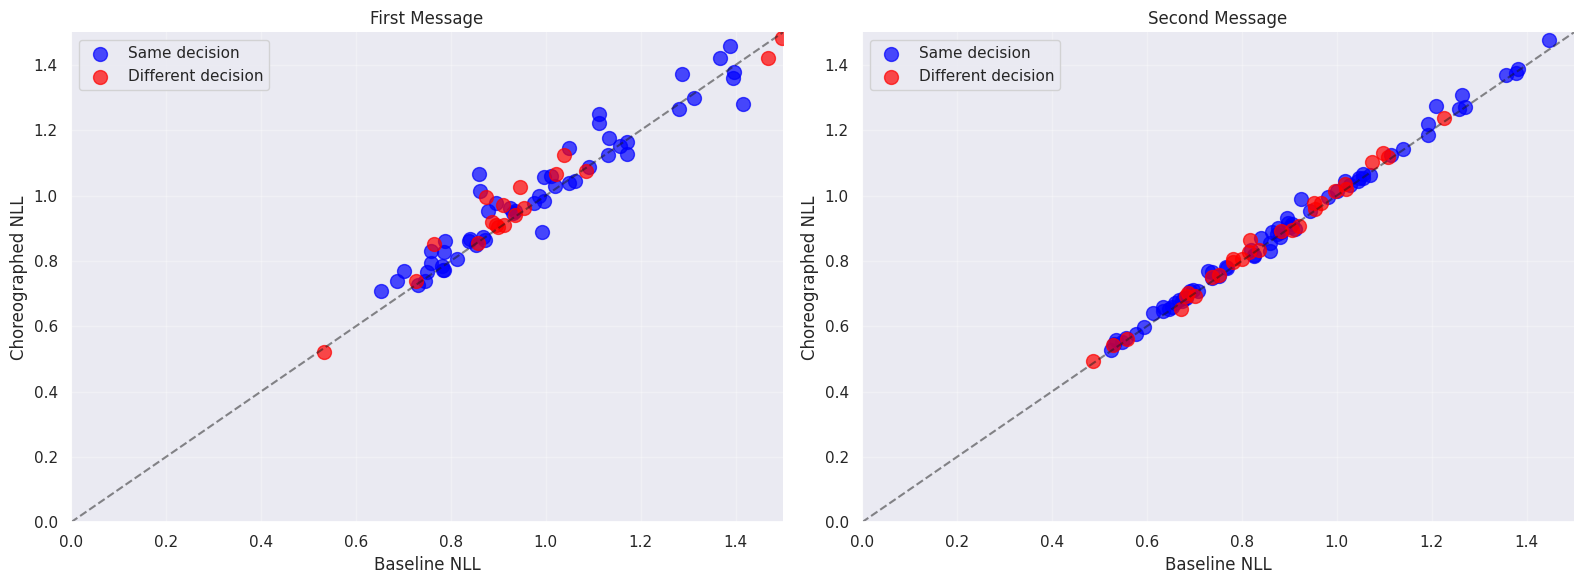

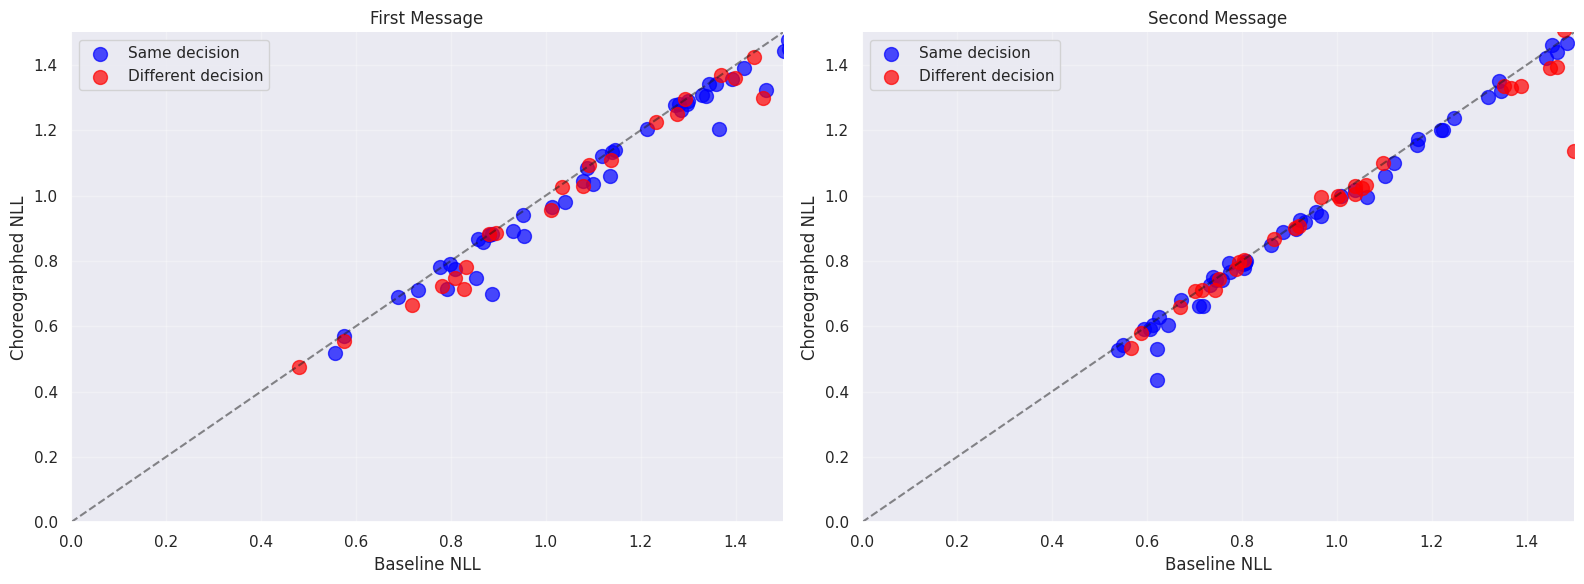

In [21]:
cached_bob_decisions = [workflow.tokenizer.decode(c['decision_ids'][1]) for c in cached_no_strategy]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_no_strategy]
differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]

fig_baseline = plot(baseline_no_strategy, differences)
fig_cached = plot(cached_no_strategy, differences)

In [22]:
fig_baseline.savefig('baseline_no_strategy.png')
fig_cached.savefig('cached_no_strategy.png')

99it [02:11,  1.32s/it]
99it [00:55,  1.77it/s]
99it [02:09,  1.30s/it]
99it [00:55,  1.79it/s]


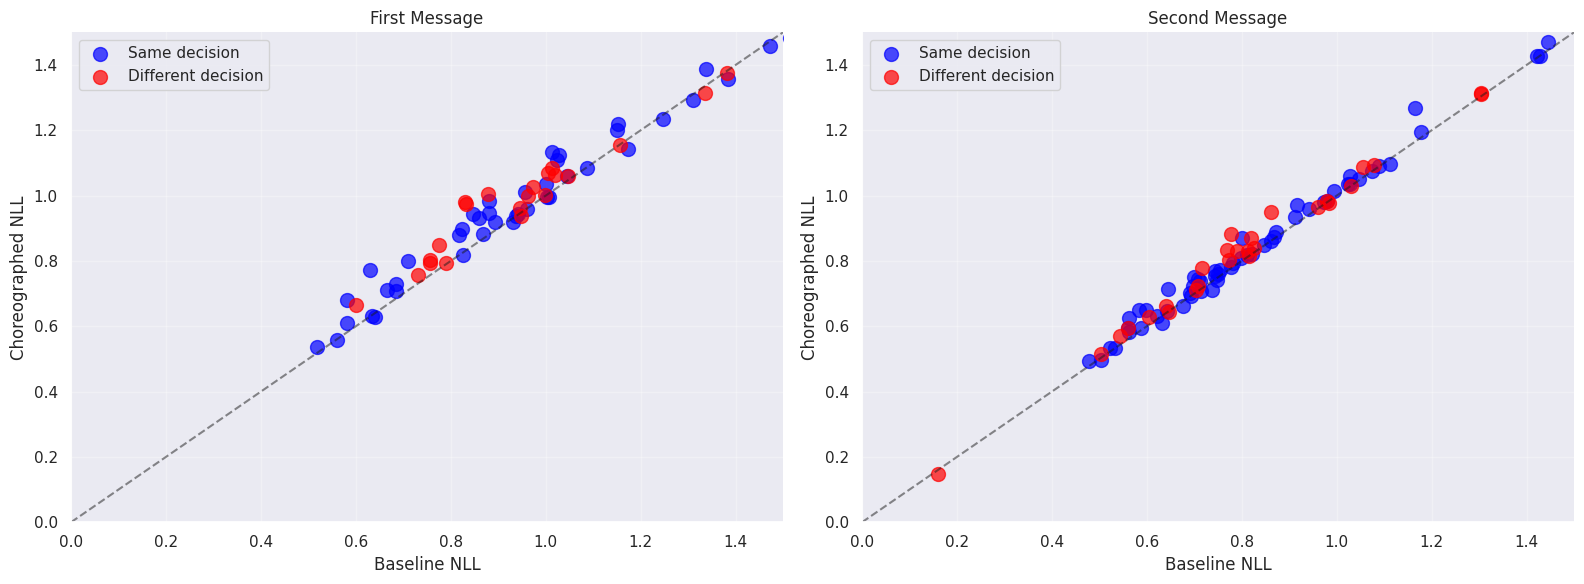

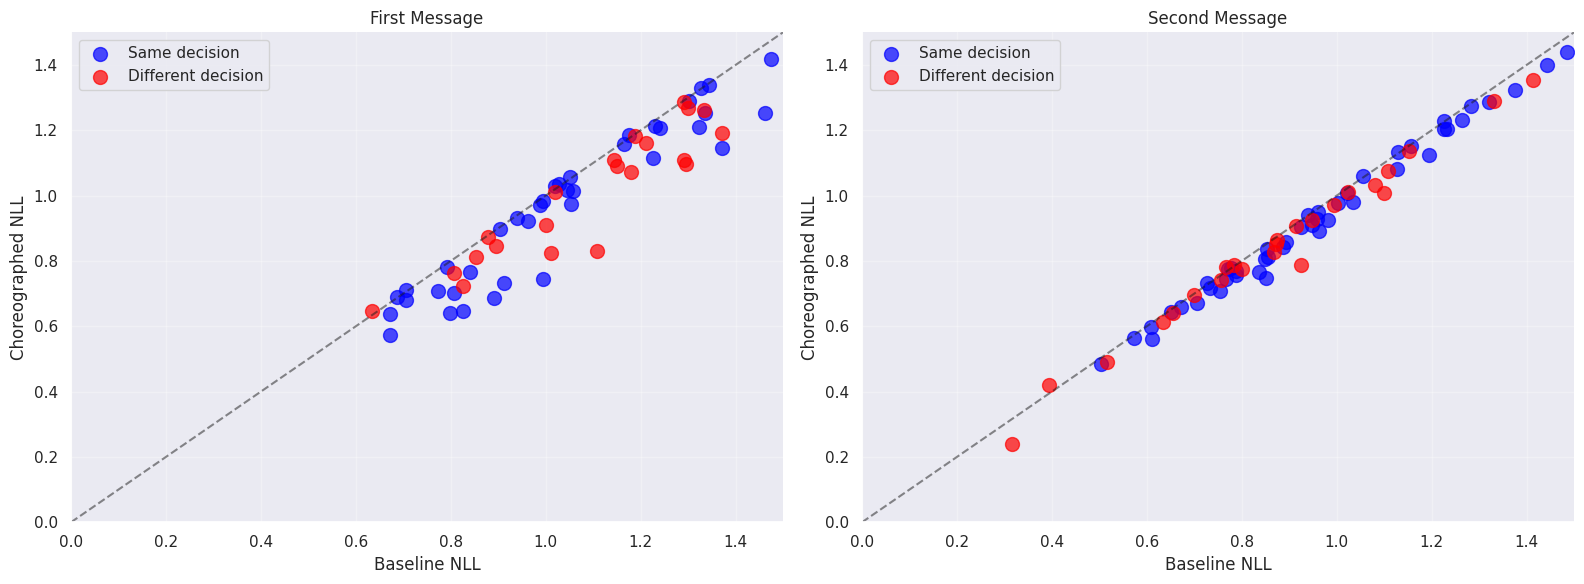

In [32]:
cached_bob_decisions = [workflow.tokenizer.decode(c['decision_ids'][1]) for c in cached_always_cooperate]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_always_cooperate]
differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]

fig_baseline = plot(baseline_always_cooperate, differences)
fig_cached = plot(cached_always_cooperate, differences)

In [33]:
fig_baseline.savefig('baseline_always_cooperate.png')
fig_cached.savefig('cached_always_cooperate.png')

100it [02:10,  1.31s/it]
100it [00:56,  1.78it/s]
100it [02:10,  1.31s/it]
100it [00:56,  1.78it/s]


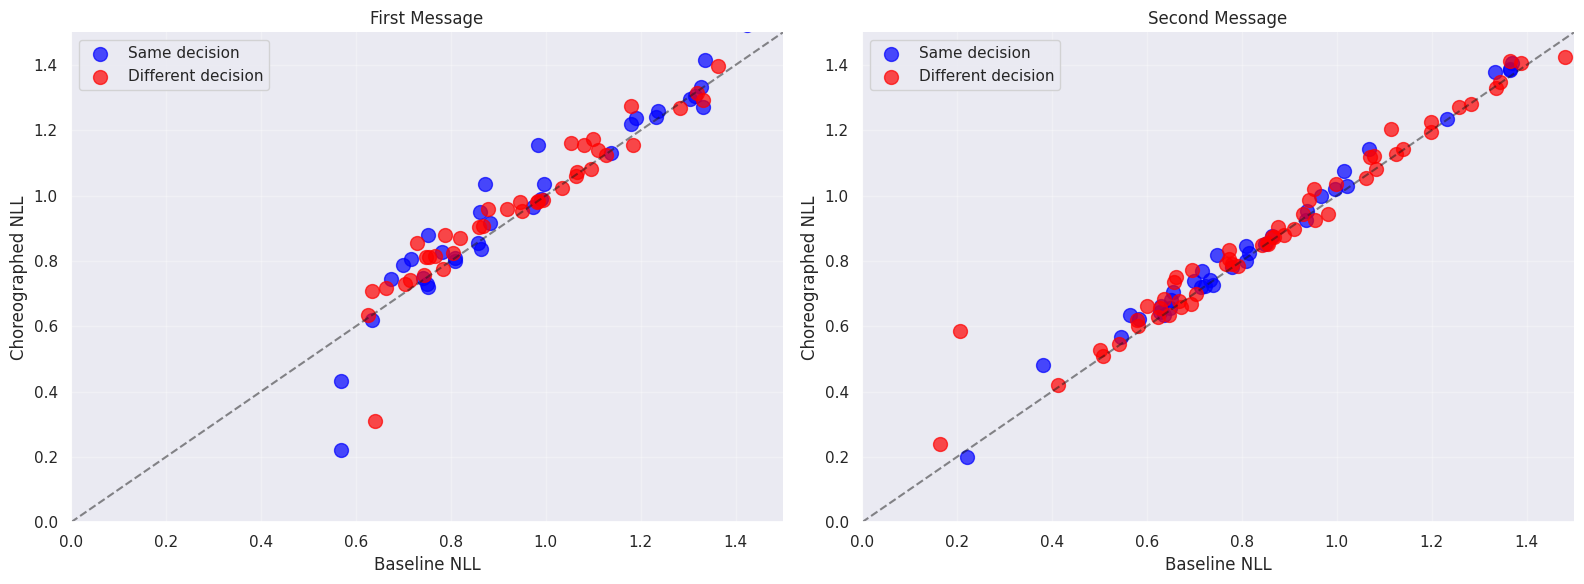

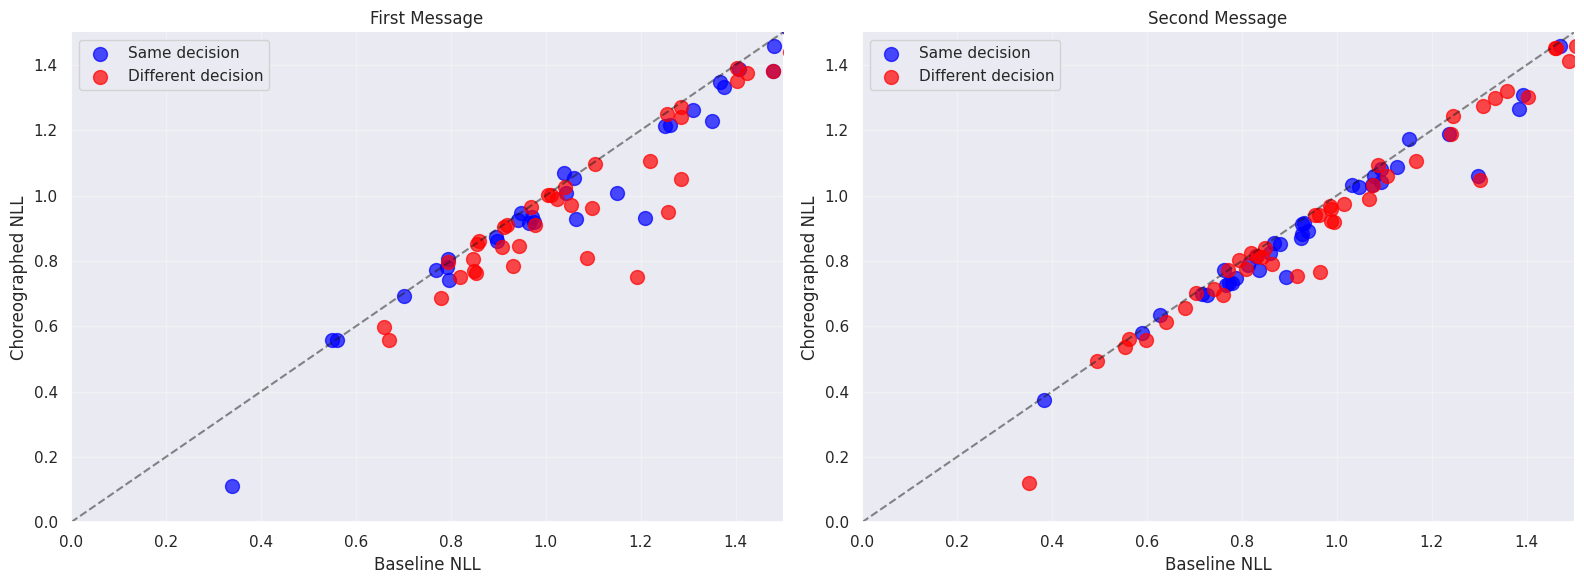

In [34]:
cached_bob_decisions = [workflow.tokenizer.decode(c['decision_ids'][1]) for c in cached_always_defect]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_always_defect]
differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]

fig_baseline = plot(baseline_always_defect, differences)
fig_cached = plot(cached_always_defect, differences)

In [35]:
fig_baseline.savefig('baseline_always_defect.png')
fig_cached.savefig('cached_always_defect.png')